In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40319/status,
Dashboard: /proxy/40319/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39857,Workers: 4
Dashboard: /proxy/40319/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.138:36101,Total threads: 4
Dashboard: /proxy/44399/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:34005,


In [3]:
# load the MOM6 data 
db='/g/data/ik11/outputs/mom6-panan/panant.db' 
expts = ['panant-v2','panant-01-hycom1','panant-01-zstar']

In [4]:
session = cc.database.create_session()

In [5]:
# time period
start_time = '1995-01-01'
end_time = '1996-01-01'

In [6]:
# get the depth
depth = cc.querying.getvar('panant-01-zstar','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# Test MOM6 at first, uo, dy and dz

In [7]:
# get 
uo = cc.querying.getvar('panant-01-hycom1','uo',session,start_time=start_time, end_time=end_time)

In [8]:
dy = cc.querying.getvar(expt='panant-01-hycom1', variable='dyCu', 
                          session=session, frequency='static', n=1)
dy

<xarray.DataArray 'dyCu' (yh: 845, xq: 3601)>
dask.array<open_dataset-df0d6c02e9b31de68a9313f10157cf80dyCu, shape=(845, 3601), dtype=float32, chunksize=(845, 3601), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -81.11 -81.07 -81.02 -80.98 ... -37.3 -37.22 -37.14
  * xq       (xq) float64 -280.0 -279.9 -279.8 -279.7 ... 79.7 79.8 79.9 80.0
Attributes:
    units:          m
    long_name:      Delta(y) at u points (meter)
    cell_methods:   time: point
    interp_method:  none
    ncfiles:        ['/g/data/ik11/outputs/mom6-panan/panant-01-hycom1/output...

In [9]:
dz_interface =cc.querying.getvar(expt='panant-01-hycom1', variable='ds_interface', 
                          session=session, n=1)
dz_interface

<xarray.DataArray 'ds_interface' (Interface: 76)>
dask.array<open_dataset-fd9e5776542e6c66afe486c77390ea60ds_interface, shape=(76,), dtype=float64, chunksize=(76,), chunktype=numpy.ndarray>
Coordinates:
  * Interface  (Interface) float64 0.0 1.08 2.16 ... 3.453e+03 3.718e+03 6e+03
Attributes:
    long_name:  Layer Center Coordinate Separation
    units:      meter
    ncfiles:    ['/g/data/ik11/outputs/mom6-panan/panant-01-hycom1/output034/...

In [10]:
# then uo * dy
uo_dy = uo*dy
uo_dy

,Array,Chunk
Bytes,12.75 GiB,19.04 MiB
Shape,"(15, 75, 845, 3601)","(1, 21, 236, 1007)"
Count,2920 Tasks,960 Chunks
Type,float32,numpy.ndarray


In [11]:
# finilay streamfunction = uo * dy*dz
dz = np.arange(75)
zl = uo.z_l

In [12]:
#dz[0] = zl[0]*2.
#dz[1] = (zl[1]-dz[0])*2
#dz[2] = (zl[2]-dz[1]-dz[0])*2

In [13]:
for i in range(74):
    dz[0] = zl[0]*2.
    dz[i+1] = (zl[i+1] - np.sum(dz[:i]))
dz

array([  1,   1,   1,   2,   2,   2,   2,   2,   2,   3,   4,   4,   3,
         3,   4,   6,   7,   6,   6,   7,   8,  10,  11,  11,  11,  13,
        16,  18,  19,  20,  21,  24,  28,  31,  34,  37,  39,  43,  49,
        55,  60,  64,  69,  76,  84,  91,  98, 105, 112, 120, 128, 136,
       143, 149, 154, 160, 167, 173, 177, 179, 180, 183, 188, 192, 193,
       192, 191, 193, 196, 199, 199, 197, 196, 197, 199])

In [14]:
# convert dz it to data array
dz1 = xr.DataArray(data = dz,dims=['z_l'])

lets test the streamfunction at 4000 m depth


In [15]:
# now calculate uo_dydz
uo_dydz = uo_dy*dz1


In [16]:
# 1 year mean flux
flux = uo_dydz.sel(time = slice(start_time,end_time)).sel(yh = slice(-90,-50)).cumsum('yh').mean('time')/1e6

### Now we test streamfunction at (x,y) in different depth layer

In [17]:
# layers at 1000m
flux_upp1 = flux.sel(z_l = slice(0,1000)).sum('z_l').load()
flux_bot1 = flux.sel(z_l = slice(1000,10000.)).sum('z_l').load()

In [18]:
# layers at 2000m
flux_upp2 = flux.sel(z_l = slice(0,2000)).sum('z_l').load()
flux_bot2 = flux.sel(z_l = slice(2000,10000.)).sum('z_l').load()

In [19]:
# layers at 3000m
flux_upp3 = flux.sel(z_l = slice(0,3000)).sum('z_l').load()
flux_bot3 = flux.sel(z_l = slice(3000,10000.)).sum('z_l').load()

In [20]:
# layers at 4000m
flux_upp4 = flux.sel(z_l = slice(0,4000)).sum('z_l').load()
flux_bot4 = flux.sel(z_l = slice(4000,10000.)).sum('z_l').load()

Text(0, 0.5, 'streamfunction (Sv)')

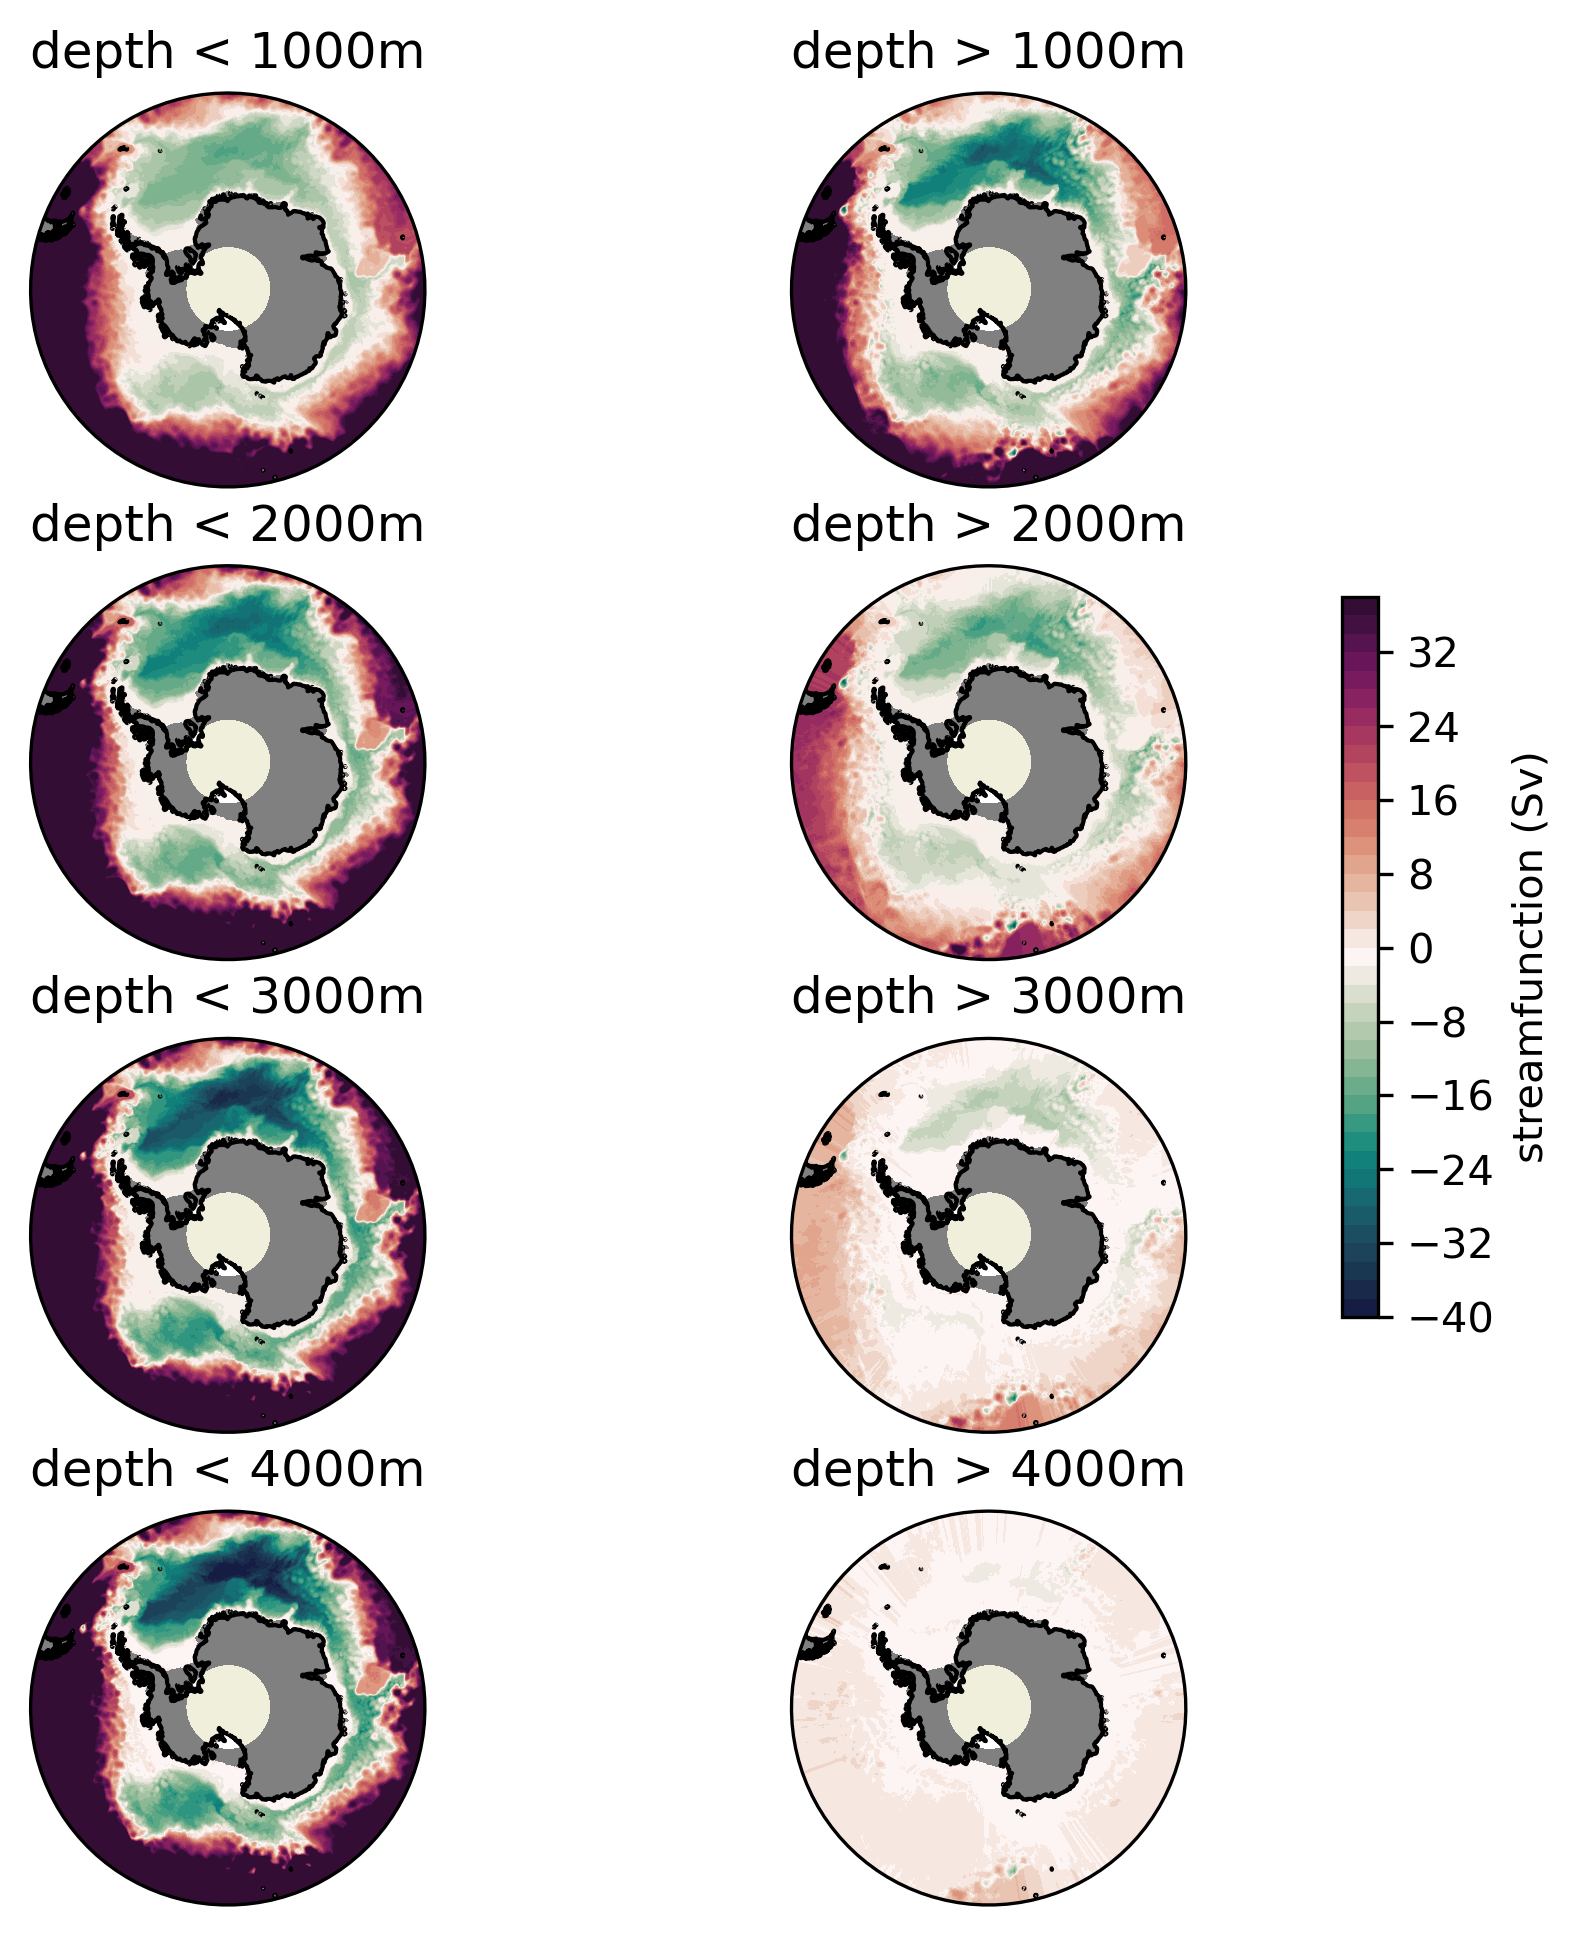

In [21]:
## plot umo and hmo
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(6, 8), dpi=300)
# flux1_upp
ax = plt.subplot(4,2,1,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_upp1.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth < 1000m')

# flux1_bot
ax = plt.subplot(4,2,2,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_bot1.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth > 1000m')

# flux2_upp
ax = plt.subplot(4,2,3,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_upp2.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth < 2000m')

# flux2_bot
ax = plt.subplot(4,2,4,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_bot2.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth > 2000m')

# flux3_upp
ax = plt.subplot(4,2,5,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_upp3.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth < 3000m')

# flux3_bot
ax = plt.subplot(4,2,6,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_bot3.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth > 3000m')

# flux4_upp
ax = plt.subplot(4,2,7,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_upp4.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth < 4000m')

# flux4_bot
ax = plt.subplot(4,2,8,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux_bot4.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('depth > 4000m')

# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')

In [22]:
# weddell
# xq = -30
flux11 = flux_upp1.sel(xq = -30,method = 'nearest')
flux21 = flux_upp2.sel(xq = -30,method = 'nearest')
flux31 = flux_upp3.sel(xq = -30,method = 'nearest')
flux41 = flux_upp4.sel(xq = -30,method = 'nearest')
# xq = 0
flux12 = flux_upp1.sel(xq = 0,method = 'nearest')
flux22 = flux_upp2.sel(xq = 0,method = 'nearest')
flux32 = flux_upp3.sel(xq = 0,method = 'nearest')
flux42 = flux_upp4.sel(xq = 0,method = 'nearest')
# xq = 30
flux13 = flux_upp1.sel(xq = 30,method = 'nearest')
flux23 = flux_upp2.sel(xq = 30,method = 'nearest')
flux33 = flux_upp3.sel(xq = 30,method = 'nearest')
flux43 = flux_upp4.sel(xq = 30,method = 'nearest')

# connection
# xq = 75
flux14 = flux_upp1.sel(xq = 50,method = 'nearest')
flux24 = flux_upp2.sel(xq = 50,method = 'nearest')
flux34 = flux_upp3.sel(xq = 50,method = 'nearest')
flux44 = flux_upp4.sel(xq = 50,method = 'nearest')
# xq = -270
flux15 = flux_upp1.sel(xq = -270,method = 'nearest')
flux25 = flux_upp2.sel(xq = -270,method = 'nearest')
flux35 = flux_upp3.sel(xq = -270,method = 'nearest')
flux45 = flux_upp4.sel(xq = -270,method = 'nearest')
# xq = -210
flux16 = flux_upp1.sel(xq = -210,method = 'nearest')
flux26 = flux_upp2.sel(xq = -210,method = 'nearest')
flux36 = flux_upp3.sel(xq = -210,method = 'nearest')
flux46 = flux_upp4.sel(xq = -210,method = 'nearest')

# Ross
# xq = -180
flux17 = flux_upp1.sel(xq = -180,method = 'nearest')
flux27 = flux_upp2.sel(xq = -180,method = 'nearest')
flux37 = flux_upp3.sel(xq = -180,method = 'nearest')
flux47 = flux_upp4.sel(xq = -180,method = 'nearest')
# xq = -150
flux18 = flux_upp1.sel(xq = -150,method = 'nearest')
flux28 = flux_upp2.sel(xq = -150,method = 'nearest')
flux38 = flux_upp3.sel(xq = -150,method = 'nearest')
flux48 = flux_upp4.sel(xq = -150,method = 'nearest')
# xq = -130
flux19 = flux_upp1.sel(xq = -130,method = 'nearest')
flux29 = flux_upp2.sel(xq = -130,method = 'nearest')
flux39 = flux_upp3.sel(xq = -130,method = 'nearest')
flux49 = flux_upp4.sel(xq = -130,method = 'nearest')

Text(0.5, 1.0, '130$^{\\circ}$ W')

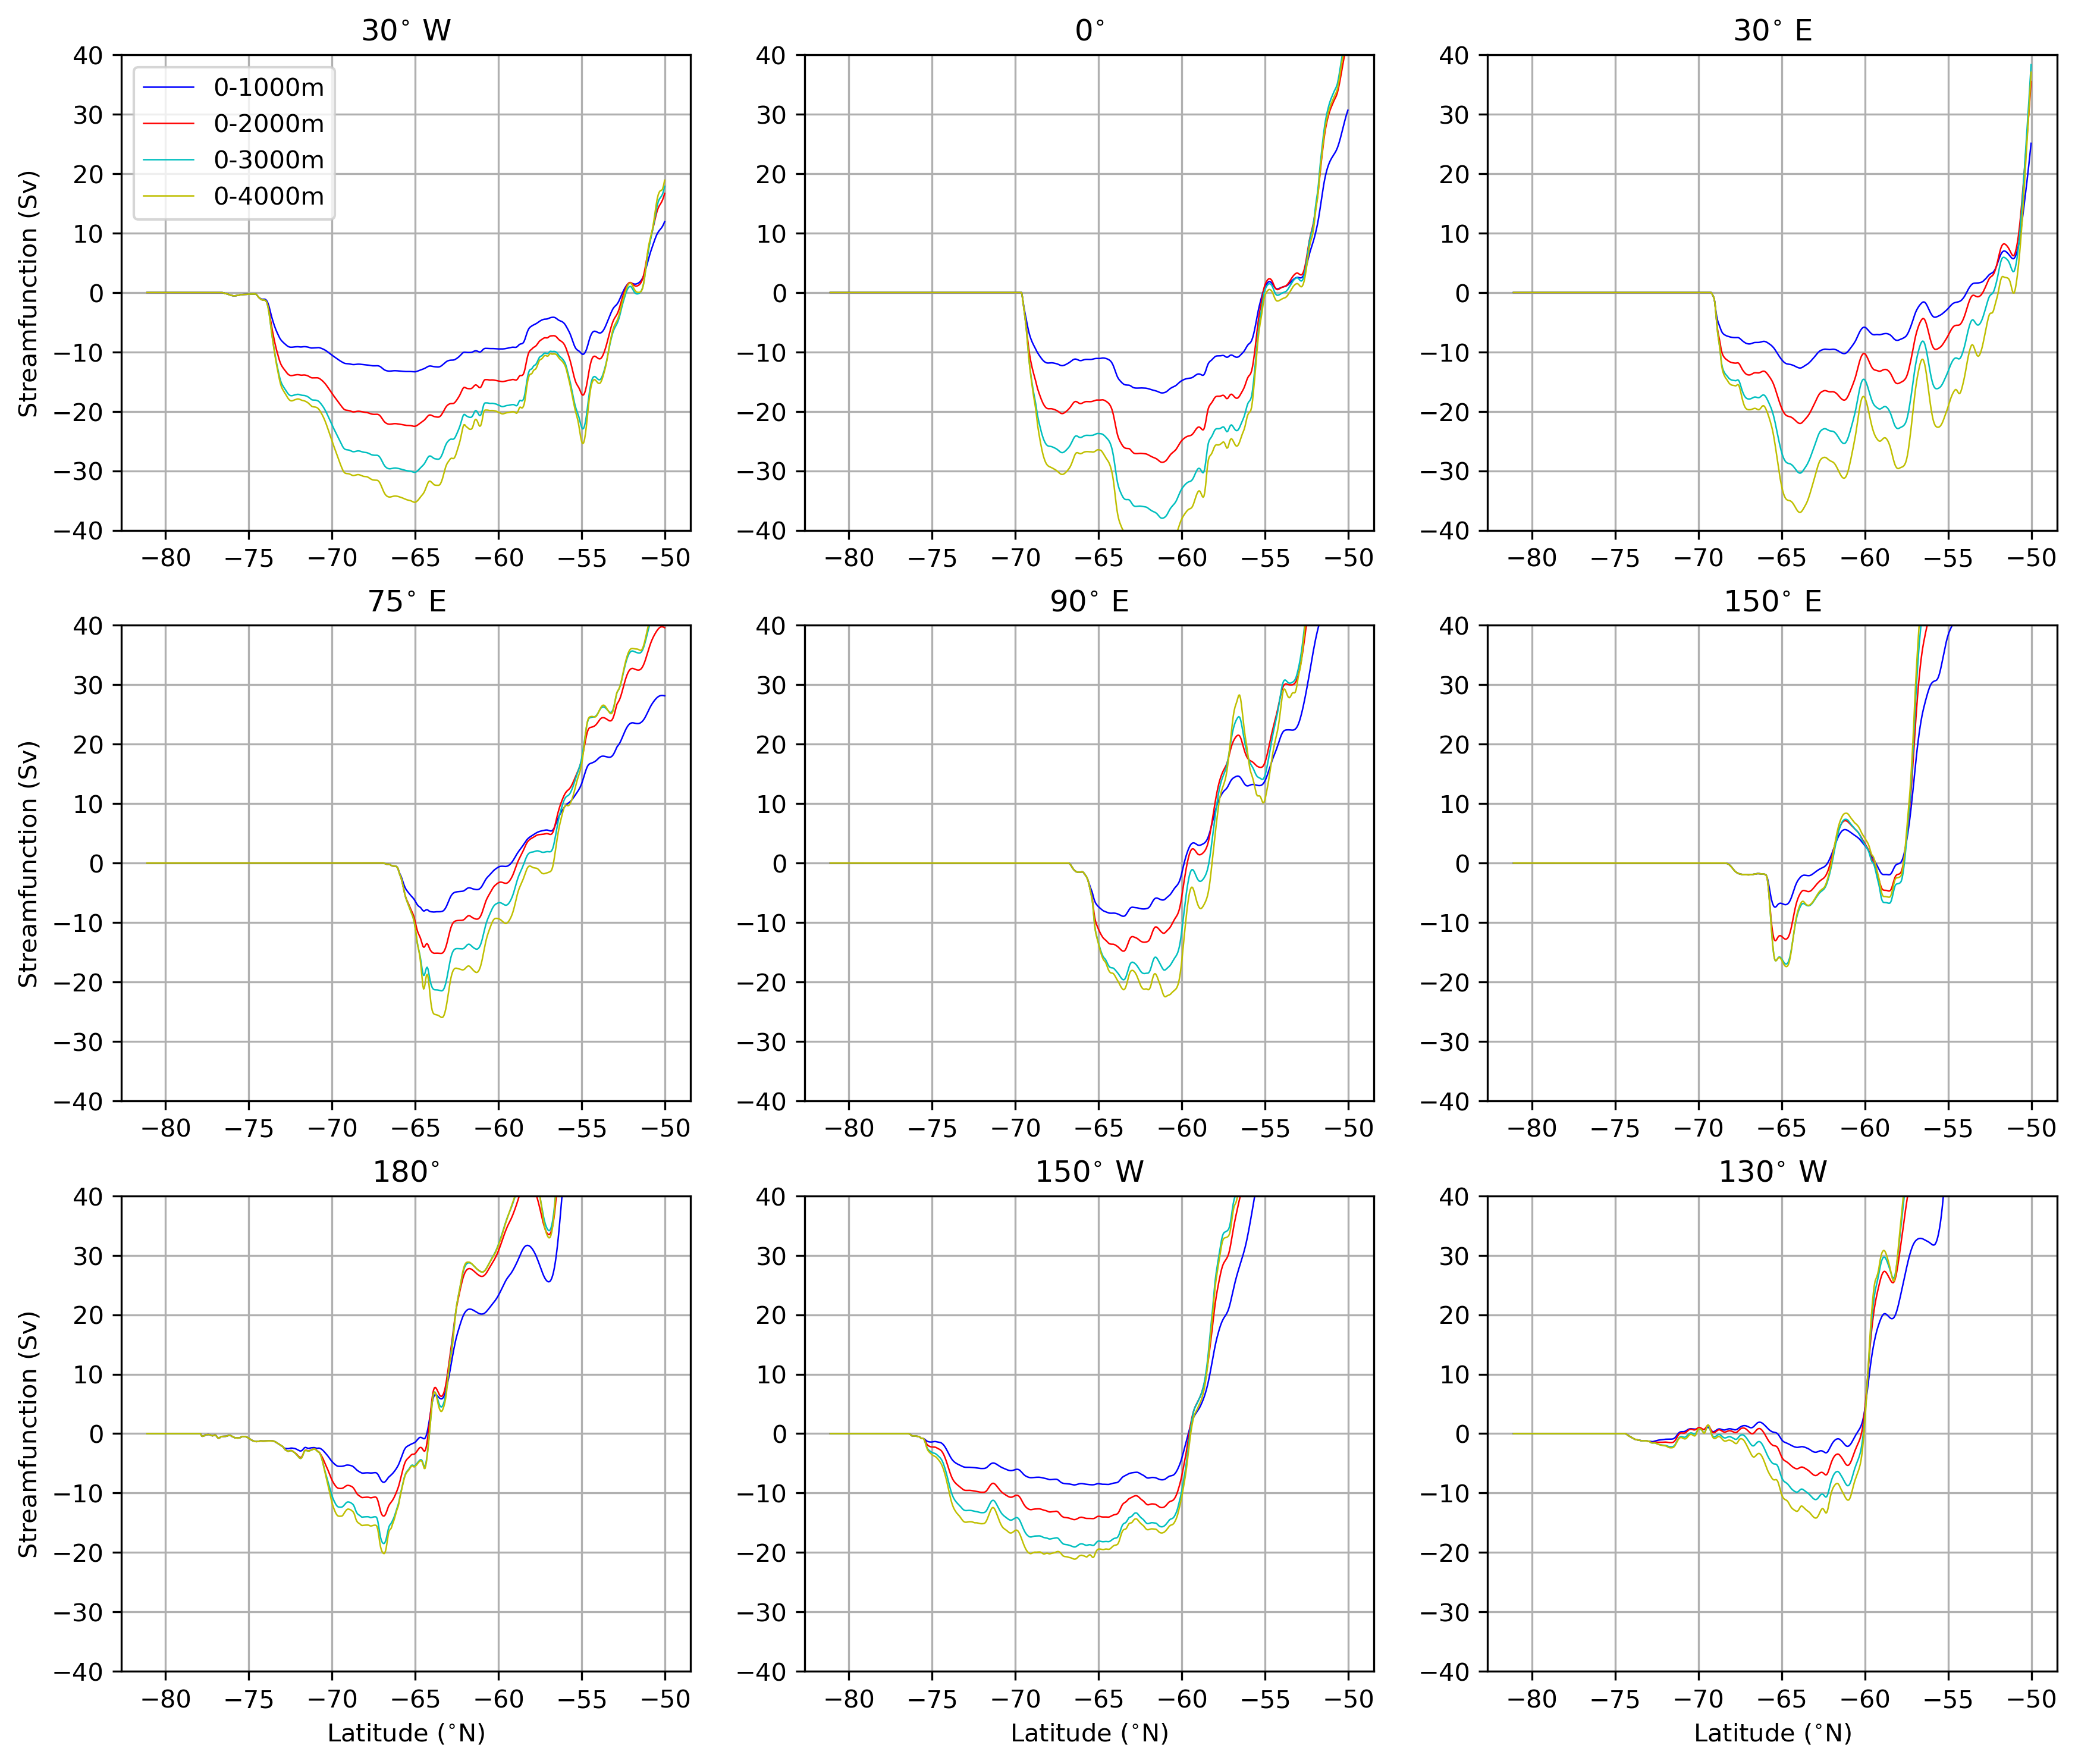

In [24]:
fig = plt.figure(figsize=(14, 12), dpi=300)
# 30W
plt.subplot(3,3,1)
plt.plot(flux11.yh.values,flux11.values,color = 'b',linewidth = 0.6)
plt.plot(flux21.yh.values,flux21.values,color = 'r',linewidth = 0.6)
plt.plot(flux31.yh.values,flux31.values,color = 'c',linewidth = 0.6)
plt.plot(flux41.yh.values,flux41.values,color = 'y',linewidth = 0.6)
plt.legend(['0-1000m','0-2000m','0-3000m','0-4000m'])
plt.ylabel('Streamfunction (Sv)')
plt.ylim(-40,40)
plt.grid()
plt.title('30$^{\circ}$ W')
# 0
plt.subplot(3,3,2)
plt.plot(flux12.yh.values,flux12.values,color = 'b',linewidth = 0.6)
plt.plot(flux22.yh.values,flux22.values,color = 'r',linewidth = 0.6)
plt.plot(flux32.yh.values,flux32.values,color = 'c',linewidth = 0.6)
plt.plot(flux42.yh.values,flux42.values,color = 'y',linewidth = 0.6)
plt.ylim(-40,40)
plt.grid()
plt.title('0$^{\circ}$')
# 30 E
plt.subplot(3,3,3)
plt.plot(flux13.yh.values,flux13.values,color = 'b',linewidth = 0.6)
plt.plot(flux23.yh.values,flux23.values,color = 'r',linewidth = 0.6)
plt.plot(flux33.yh.values,flux33.values,color = 'c',linewidth = 0.6)
plt.plot(flux43.yh.values,flux43.values,color = 'y',linewidth = 0.6)
plt.ylim(-40,40)
plt.grid()
plt.title('30$^{\circ}$ E')
# 75 E
plt.subplot(3,3,4)
plt.plot(flux14.yh.values,flux14.values,color = 'b',linewidth = 0.6)
plt.plot(flux24.yh.values,flux24.values,color = 'r',linewidth = 0.6)
plt.plot(flux34.yh.values,flux34.values,color = 'c',linewidth = 0.6)
plt.plot(flux44.yh.values,flux44.values,color = 'y',linewidth = 0.6)
plt.ylabel('Streamfunction (Sv)')
plt.ylim(-40,40)
plt.grid()
plt.title('75$^{\circ}$ E')

# 90 E
plt.subplot(3,3,5)
plt.plot(flux15.yh.values,flux15.values,color = 'b',linewidth = 0.6)
plt.plot(flux25.yh.values,flux25.values,color = 'r',linewidth = 0.6)
plt.plot(flux35.yh.values,flux35.values,color = 'c',linewidth = 0.6)
plt.plot(flux45.yh.values,flux45.values,color = 'y',linewidth = 0.6)
plt.ylim(-40,40)
plt.grid()
plt.title('90$^{\circ}$ E')

# 150 E
plt.subplot(3,3,6)
plt.plot(flux16.yh.values,flux16.values,color = 'b',linewidth = 0.6)
plt.plot(flux26.yh.values,flux26.values,color = 'r',linewidth = 0.6)
plt.plot(flux36.yh.values,flux36.values,color = 'c',linewidth = 0.6)
plt.plot(flux46.yh.values,flux46.values,color = 'y',linewidth = 0.6)
plt.ylim(-40,40)
plt.grid()
plt.title('150$^{\circ}$ E')

# 180
plt.subplot(3,3,7)
plt.plot(flux17.yh.values,flux17.values,color = 'b',linewidth = 0.6)
plt.plot(flux27.yh.values,flux27.values,color = 'r',linewidth = 0.6)
plt.plot(flux37.yh.values,flux37.values,color = 'c',linewidth = 0.6)
plt.plot(flux47.yh.values,flux47.values,color = 'y',linewidth = 0.6)
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylabel('Streamfunction (Sv)')
plt.ylim(-40,40)
plt.grid()
plt.title('180$^{\circ}$')

# 150 W
plt.subplot(3,3,8)
plt.plot(flux18.yh.values,flux18.values,color = 'b',linewidth = 0.6)
plt.plot(flux28.yh.values,flux28.values,color = 'r',linewidth = 0.6)
plt.plot(flux38.yh.values,flux38.values,color = 'c',linewidth = 0.6)
plt.plot(flux48.yh.values,flux48.values,color = 'y',linewidth = 0.6)
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylim(-40,40)
plt.grid()
plt.title('150$^{\circ}$ W')

# 130 W
plt.subplot(3,3,9)
plt.plot(flux19.yh.values,flux19.values,color = 'b',linewidth = 0.6)
plt.plot(flux29.yh.values,flux29.values,color = 'r',linewidth = 0.6)
plt.plot(flux39.yh.values,flux39.values,color = 'c',linewidth = 0.6)
plt.plot(flux49.yh.values,flux49.values,color = 'y',linewidth = 0.6)
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylim(-40,40)
plt.grid()
plt.title('130$^{\circ}$ W')

### divided layers

In [22]:
# different 1000m-layers
flux1 = flux.sel(z_l = slice(0,1000)).sum('z_l').load()
flux2 = flux.sel(z_l = slice(1000,2000)).sum('z_l').load()
flux3 = flux.sel(z_l = slice(2000,3000)).sum('z_l').load()
flux4 = flux.sel(z_l = slice(3000,4000)).sum('z_l').load()

Text(0, 0.5, 'streamfunction (Sv)')

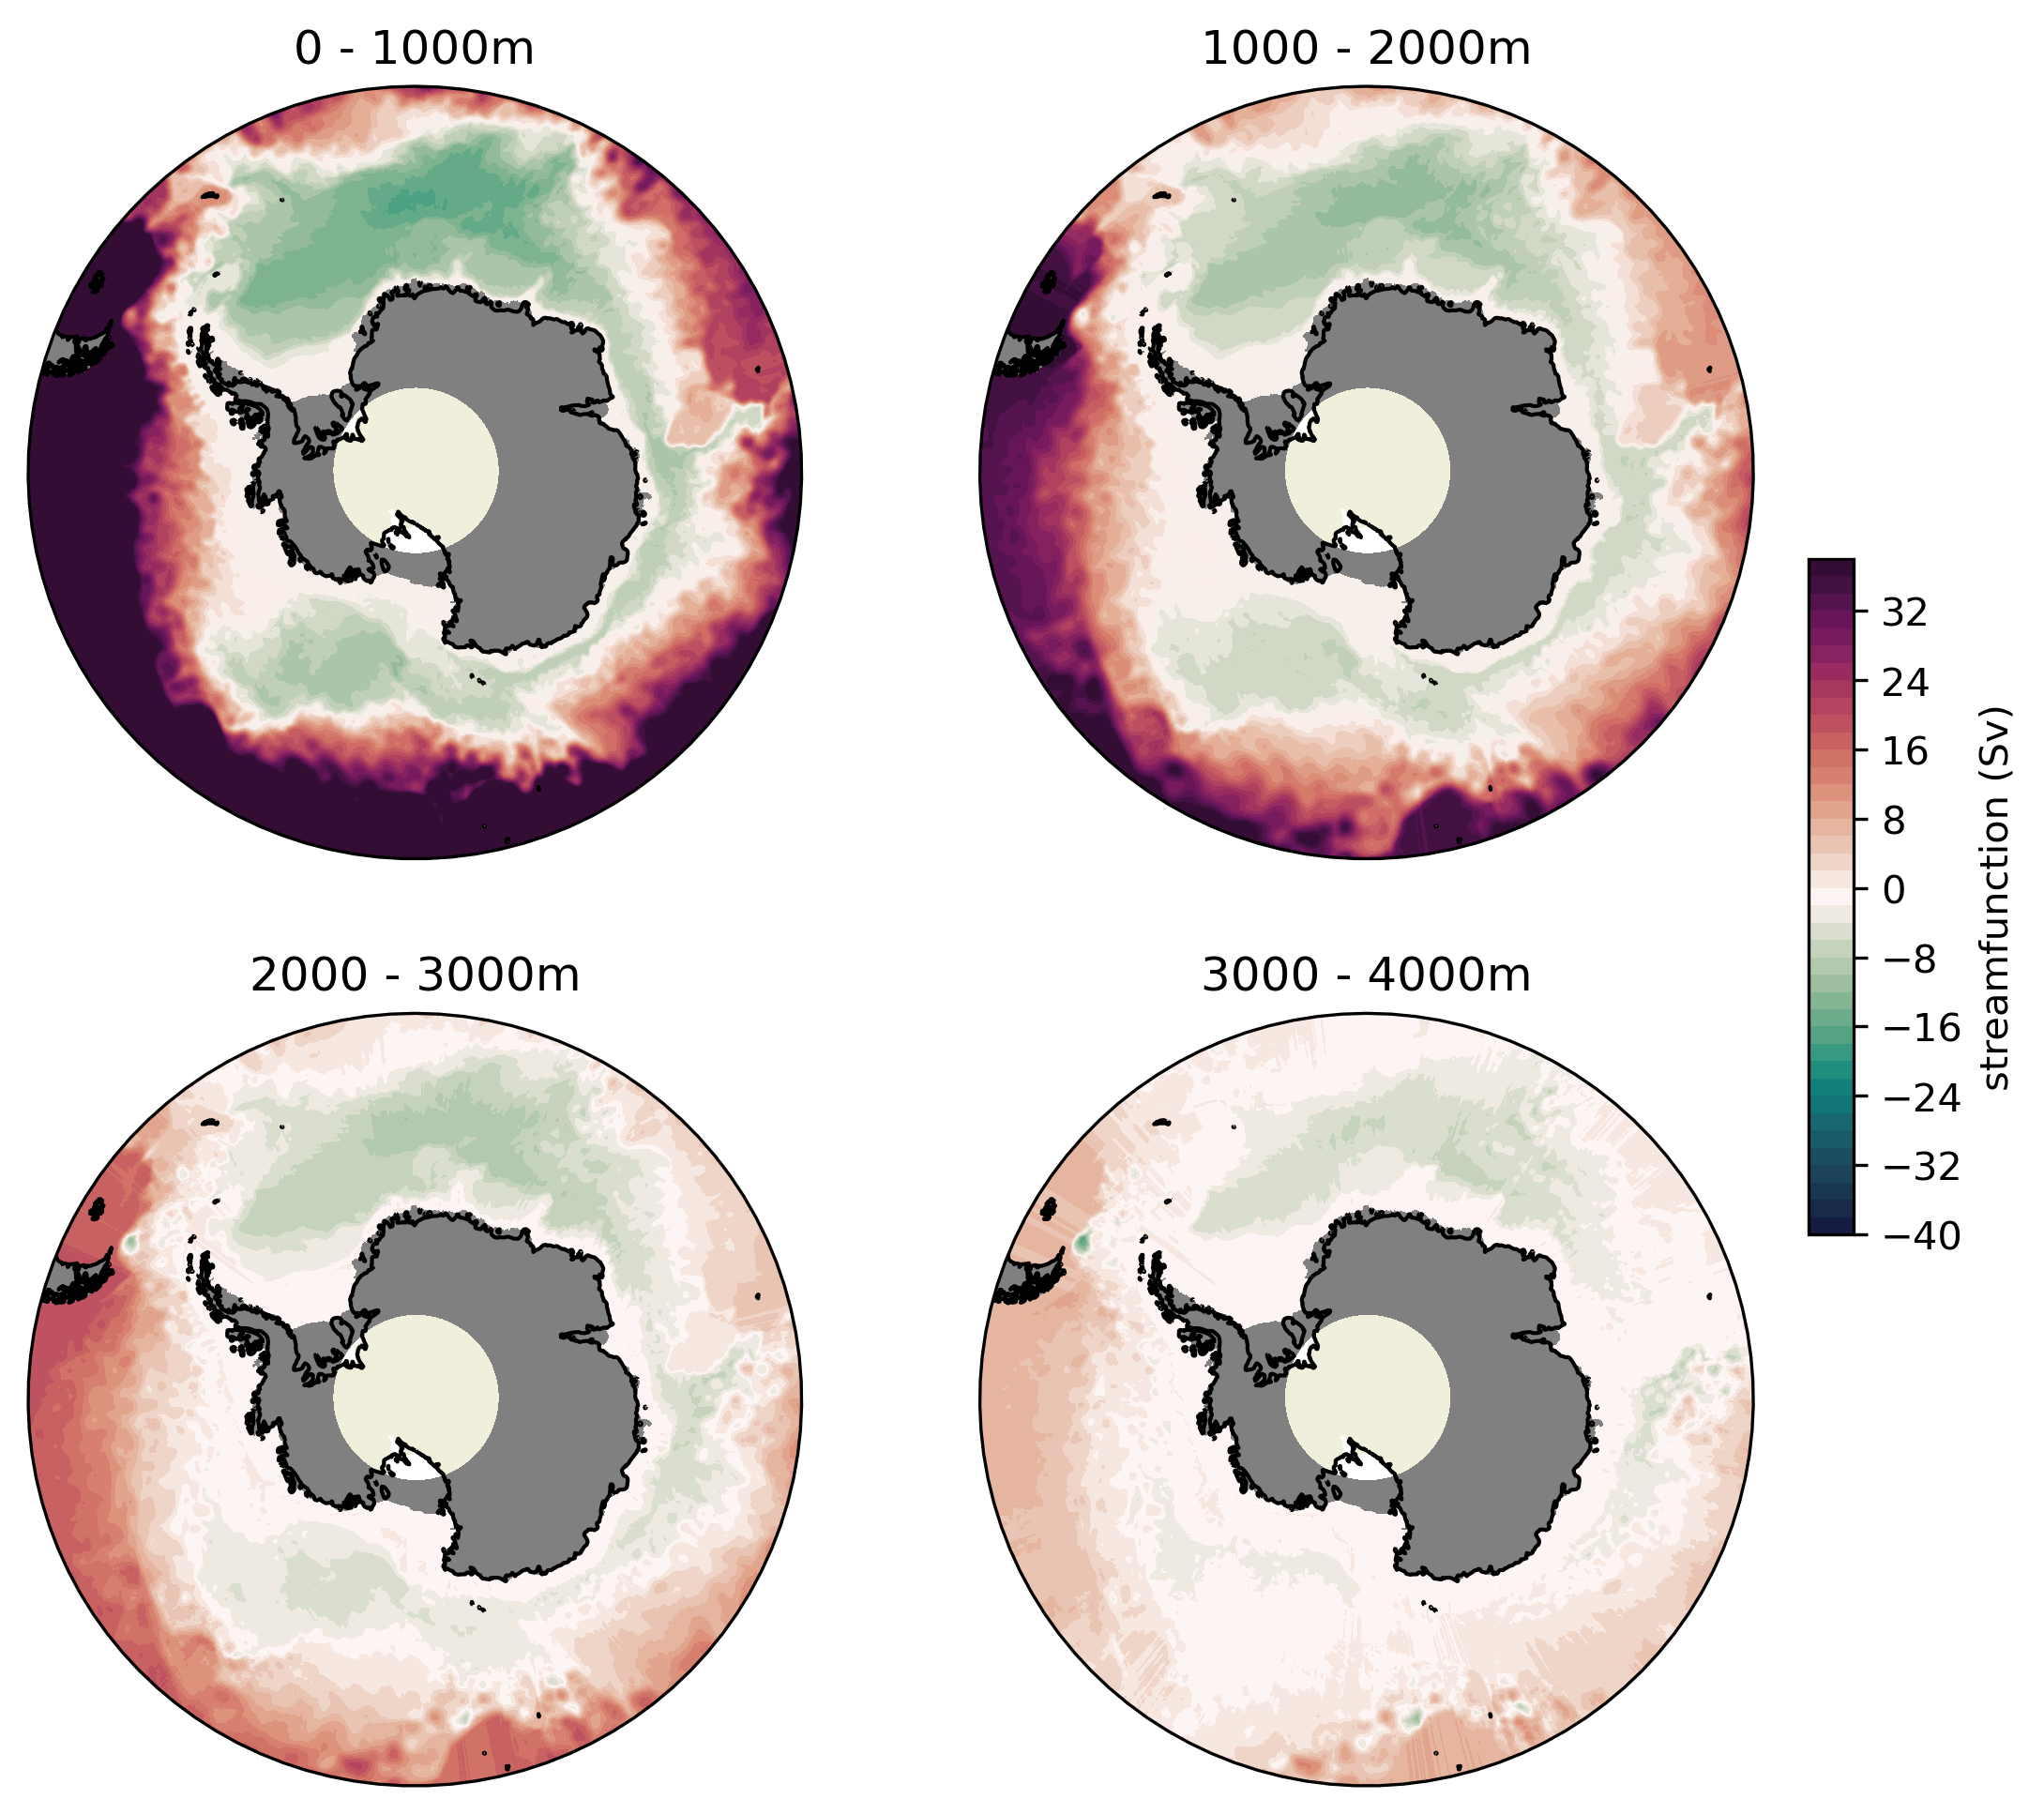

In [23]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 8), dpi=300)
# flux1
ax = plt.subplot(2,2,1,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux1.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('0 - 1000m')

# flux2
ax = plt.subplot(2,2,2,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux2.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('1000 - 2000m')

# flux3
ax = plt.subplot(2,2,3,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux3.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('2000 - 3000m')

# flux4
ax = plt.subplot(2,2,4,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux4.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('3000 - 4000m')

# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')

### Now test flux of 4 layers at different longitude

In [43]:
# weddell
# xq = -30
flux11 = flux1.sel(xq = -30,method = 'nearest')
flux21 = flux2.sel(xq = -30,method = 'nearest')
flux31 = flux3.sel(xq = -30,method = 'nearest')
flux41 = flux4.sel(xq = -30,method = 'nearest')
# xq = 0
flux12 = flux1.sel(xq = 0,method = 'nearest')
flux22 = flux2.sel(xq = 0,method = 'nearest')
flux32 = flux3.sel(xq = 0,method = 'nearest')
flux42 = flux4.sel(xq = 0,method = 'nearest')
# xq = 30
flux13 = flux1.sel(xq = 30,method = 'nearest')
flux23 = flux2.sel(xq = 30,method = 'nearest')
flux33 = flux3.sel(xq = 30,method = 'nearest')
flux43 = flux4.sel(xq = 30,method = 'nearest')

# connection
# xq = 75
flux14 = flux1.sel(xq = 50,method = 'nearest')
flux24 = flux2.sel(xq = 50,method = 'nearest')
flux34 = flux3.sel(xq = 50,method = 'nearest')
flux44 = flux4.sel(xq = 50,method = 'nearest')
# xq = -270
flux15 = flux1.sel(xq = -270,method = 'nearest')
flux25 = flux2.sel(xq = -270,method = 'nearest')
flux35 = flux3.sel(xq = -270,method = 'nearest')
flux45 = flux4.sel(xq = -270,method = 'nearest')
# xq = -210
flux16 = flux1.sel(xq = -210,method = 'nearest')
flux26 = flux2.sel(xq = -210,method = 'nearest')
flux36 = flux3.sel(xq = -210,method = 'nearest')
flux46 = flux4.sel(xq = -210,method = 'nearest')

# Ross
# xq = -180
flux17 = flux1.sel(xq = -180,method = 'nearest')
flux27 = flux2.sel(xq = -180,method = 'nearest')
flux37 = flux3.sel(xq = -180,method = 'nearest')
flux47 = flux4.sel(xq = -180,method = 'nearest')
# xq = -150
flux18 = flux1.sel(xq = -150,method = 'nearest')
flux28 = flux2.sel(xq = -150,method = 'nearest')
flux38 = flux3.sel(xq = -150,method = 'nearest')
flux48 = flux4.sel(xq = -150,method = 'nearest')
# xq = -130
flux19 = flux1.sel(xq = -130,method = 'nearest')
flux29 = flux2.sel(xq = -130,method = 'nearest')
flux39 = flux3.sel(xq = -130,method = 'nearest')
flux49 = flux4.sel(xq = -130,method = 'nearest')

Text(0.5, 1.0, '130$^{\\circ}$ W')

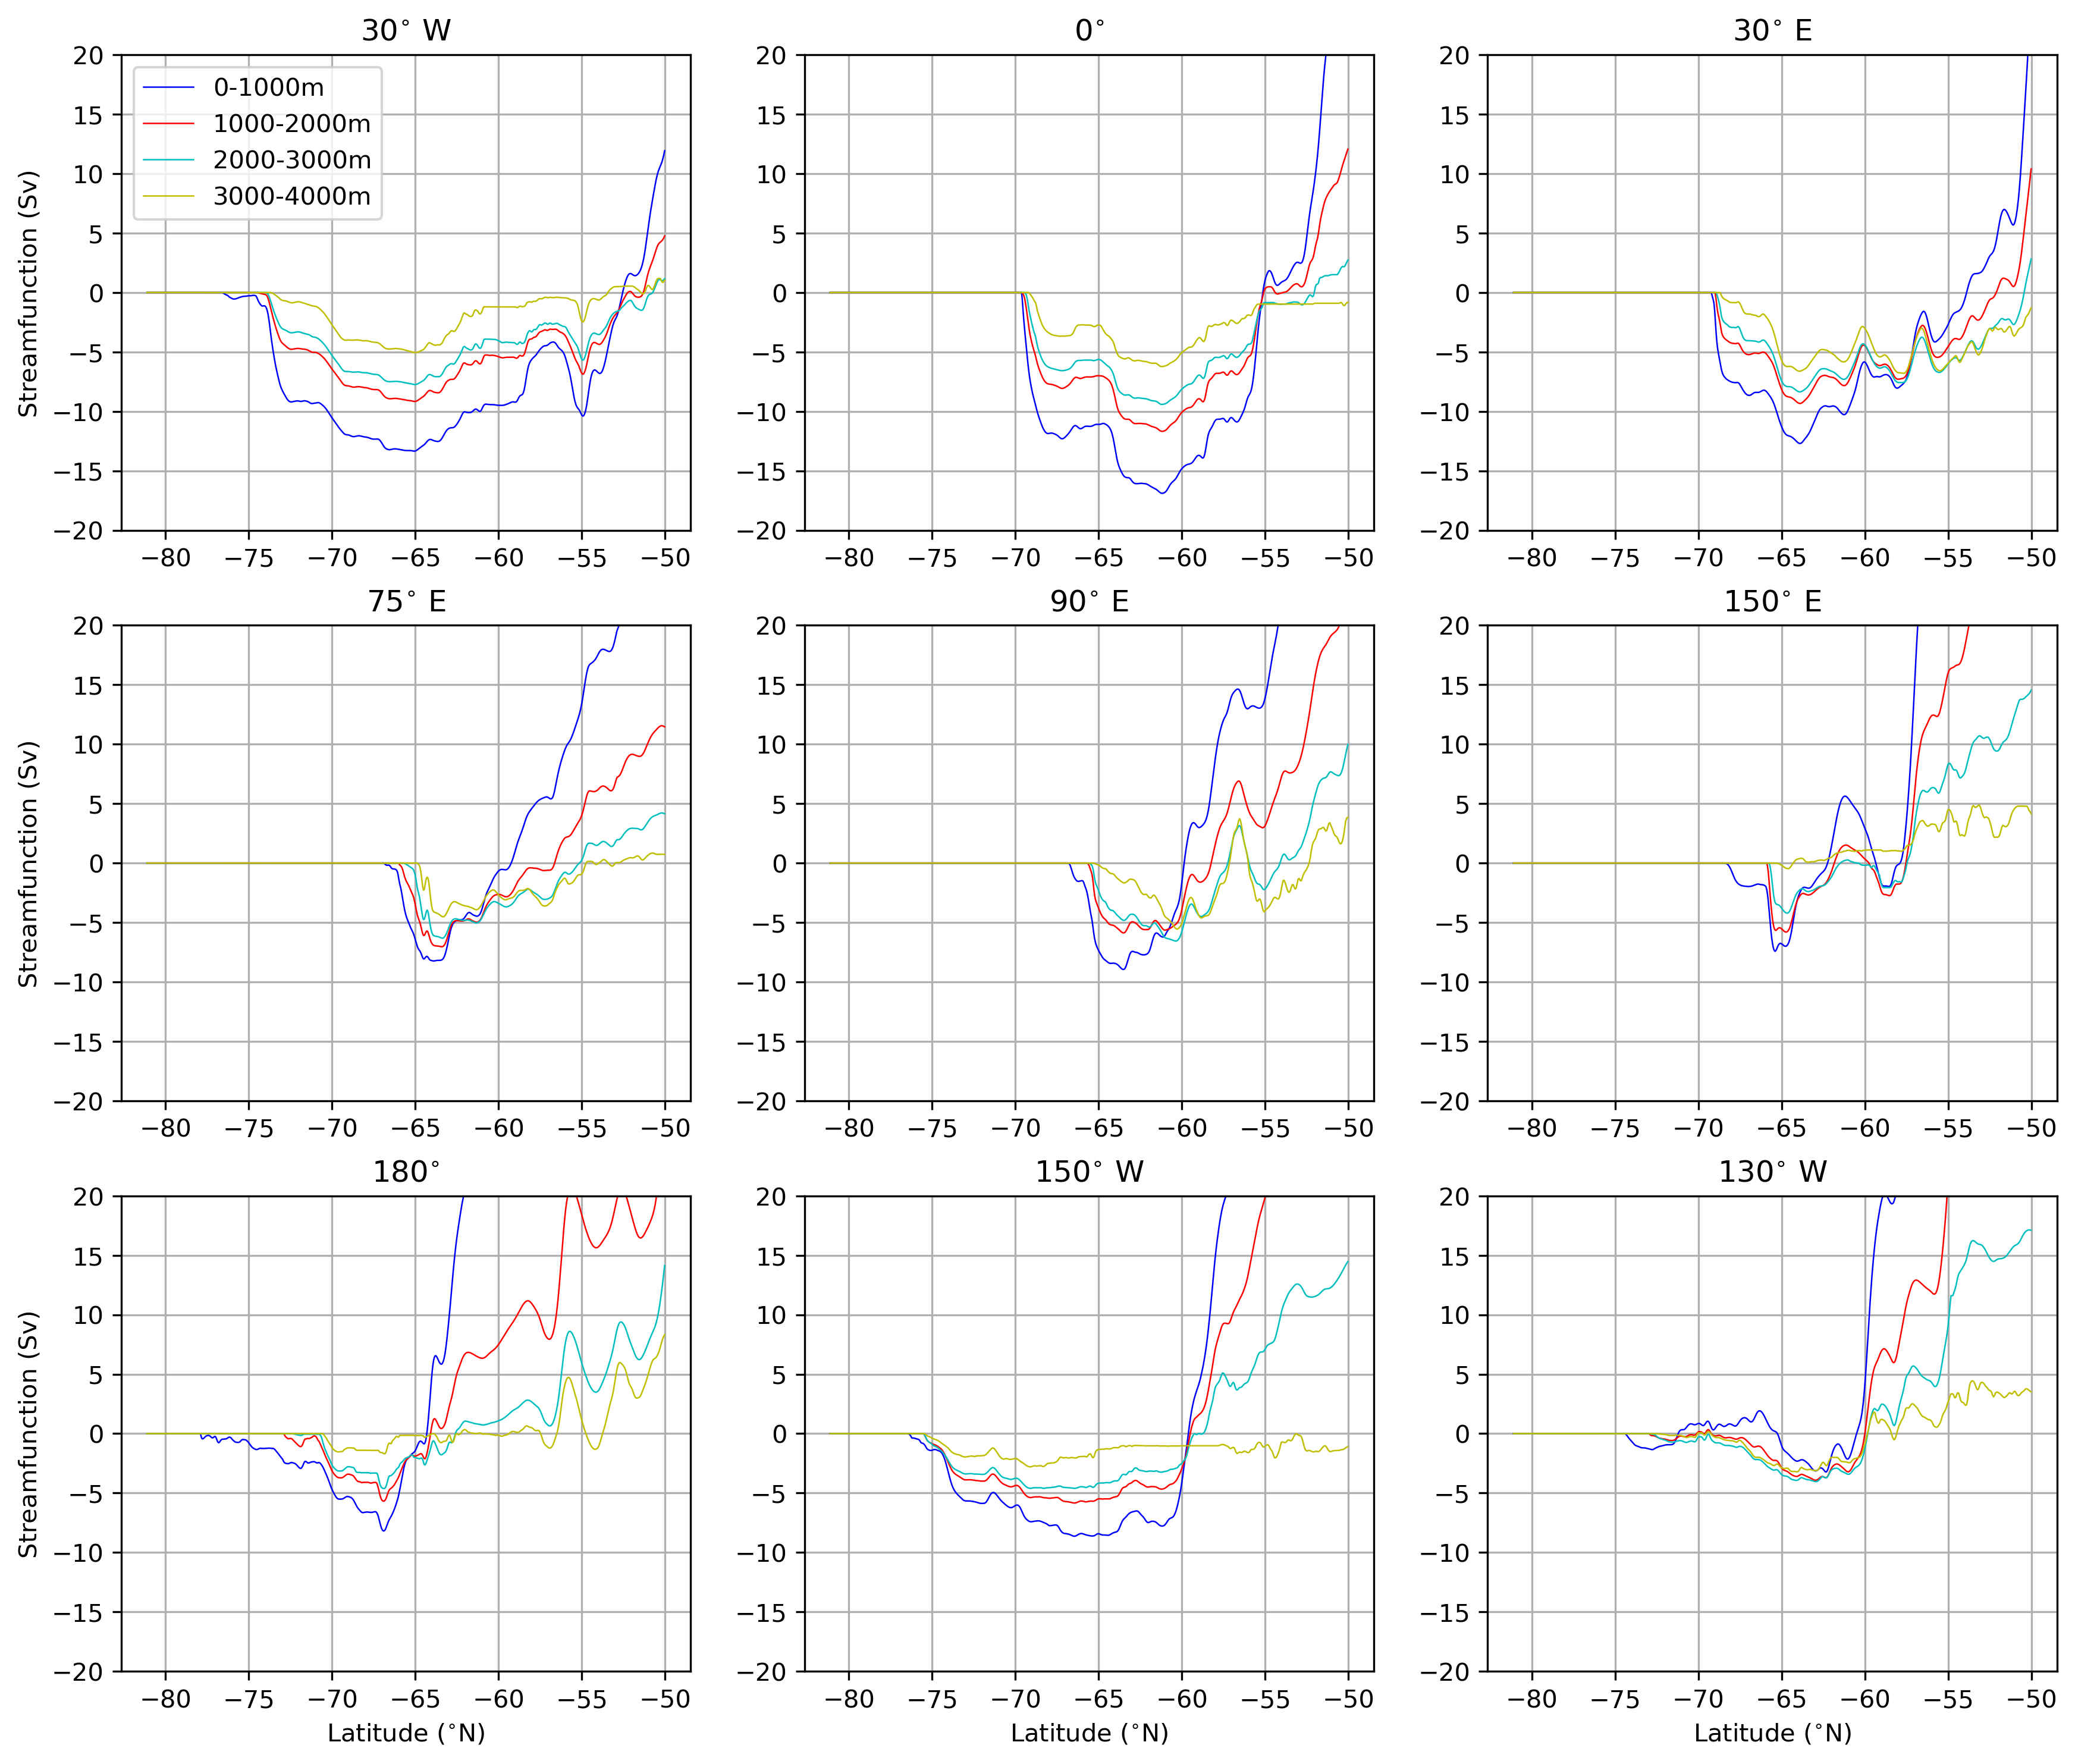

In [53]:
fig = plt.figure(figsize=(14, 12), dpi=300)
# 30W
plt.subplot(3,3,1)
plt.plot(flux11.yh.values,flux11.values,color = 'b',linewidth = 0.6)
plt.plot(flux21.yh.values,flux21.values,color = 'r',linewidth = 0.6)
plt.plot(flux31.yh.values,flux31.values,color = 'c',linewidth = 0.6)
plt.plot(flux41.yh.values,flux41.values,color = 'y',linewidth = 0.6)
plt.legend(['0-1000m','1000-2000m','2000-3000m','3000-4000m'])
plt.ylabel('Streamfunction (Sv)')
plt.ylim(-20,20)
plt.grid()
plt.title('30$^{\circ}$ W')
# 0
plt.subplot(3,3,2)
plt.plot(flux12.yh.values,flux12.values,color = 'b',linewidth = 0.6)
plt.plot(flux22.yh.values,flux22.values,color = 'r',linewidth = 0.6)
plt.plot(flux32.yh.values,flux32.values,color = 'c',linewidth = 0.6)
plt.plot(flux42.yh.values,flux42.values,color = 'y',linewidth = 0.6)
plt.ylim(-20,20)
plt.grid()
plt.title('0$^{\circ}$')
# 30 E
plt.subplot(3,3,3)
plt.plot(flux13.yh.values,flux13.values,color = 'b',linewidth = 0.6)
plt.plot(flux23.yh.values,flux23.values,color = 'r',linewidth = 0.6)
plt.plot(flux33.yh.values,flux33.values,color = 'c',linewidth = 0.6)
plt.plot(flux43.yh.values,flux43.values,color = 'y',linewidth = 0.6)
plt.ylim(-20,20)
plt.grid()
plt.title('30$^{\circ}$ E')
# 75 E
plt.subplot(3,3,4)
plt.plot(flux14.yh.values,flux14.values,color = 'b',linewidth = 0.6)
plt.plot(flux24.yh.values,flux24.values,color = 'r',linewidth = 0.6)
plt.plot(flux34.yh.values,flux34.values,color = 'c',linewidth = 0.6)
plt.plot(flux44.yh.values,flux44.values,color = 'y',linewidth = 0.6)
plt.ylabel('Streamfunction (Sv)')
plt.ylim(-20,20)
plt.grid()
plt.title('75$^{\circ}$ E')

# 90 E
plt.subplot(3,3,5)
plt.plot(flux15.yh.values,flux15.values,color = 'b',linewidth = 0.6)
plt.plot(flux25.yh.values,flux25.values,color = 'r',linewidth = 0.6)
plt.plot(flux35.yh.values,flux35.values,color = 'c',linewidth = 0.6)
plt.plot(flux45.yh.values,flux45.values,color = 'y',linewidth = 0.6)
plt.ylim(-20,20)
plt.grid()
plt.title('90$^{\circ}$ E')

# 150 E
plt.subplot(3,3,6)
plt.plot(flux16.yh.values,flux16.values,color = 'b',linewidth = 0.6)
plt.plot(flux26.yh.values,flux26.values,color = 'r',linewidth = 0.6)
plt.plot(flux36.yh.values,flux36.values,color = 'c',linewidth = 0.6)
plt.plot(flux46.yh.values,flux46.values,color = 'y',linewidth = 0.6)
plt.ylim(-20,20)
plt.grid()
plt.title('150$^{\circ}$ E')

# 180
plt.subplot(3,3,7)
plt.plot(flux17.yh.values,flux17.values,color = 'b',linewidth = 0.6)
plt.plot(flux27.yh.values,flux27.values,color = 'r',linewidth = 0.6)
plt.plot(flux37.yh.values,flux37.values,color = 'c',linewidth = 0.6)
plt.plot(flux47.yh.values,flux47.values,color = 'y',linewidth = 0.6)
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylabel('Streamfunction (Sv)')
plt.ylim(-20,20)
plt.grid()
plt.title('180$^{\circ}$')

# 150 W
plt.subplot(3,3,8)
plt.plot(flux18.yh.values,flux18.values,color = 'b',linewidth = 0.6)
plt.plot(flux28.yh.values,flux28.values,color = 'r',linewidth = 0.6)
plt.plot(flux38.yh.values,flux38.values,color = 'c',linewidth = 0.6)
plt.plot(flux48.yh.values,flux48.values,color = 'y',linewidth = 0.6)
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylim(-20,20)
plt.grid()
plt.title('150$^{\circ}$ W')

# 130 W
plt.subplot(3,3,9)
plt.plot(flux19.yh.values,flux19.values,color = 'b',linewidth = 0.6)
plt.plot(flux29.yh.values,flux29.values,color = 'r',linewidth = 0.6)
plt.plot(flux39.yh.values,flux39.values,color = 'c',linewidth = 0.6)
plt.plot(flux49.yh.values,flux49.values,color = 'y',linewidth = 0.6)
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylim(-20,20)
plt.grid()
plt.title('130$^{\circ}$ W')

In [32]:
transect1 = flux.sel(xq = -50, method = 'nearest').load()

In [19]:
transect2 = flux.sel(xq = -30, method = 'nearest').load()

In [20]:
transect3 = flux.sel(xq = 0, method = 'nearest').load()

In [21]:
transect4 = flux.sel(xq = 30, method = 'nearest').load()

In [22]:
transect5 = flux.sel(xq = 60, method = 'nearest').load()

In [23]:
transect6 = flux.sel(xq = -270, method = 'nearest').load()

In [24]:
transect7 = flux.sel(xq = -240, method = 'nearest').load()

In [25]:
transect8 = flux.sel(xq = -210, method = 'nearest').load()

In [26]:
transect9 = flux.sel(xq = -180, method = 'nearest').load()

In [27]:
transect10 = flux.sel(xq = -150, method = 'nearest').load()

Text(0, 0.5, 'streamfunction (Sv)')

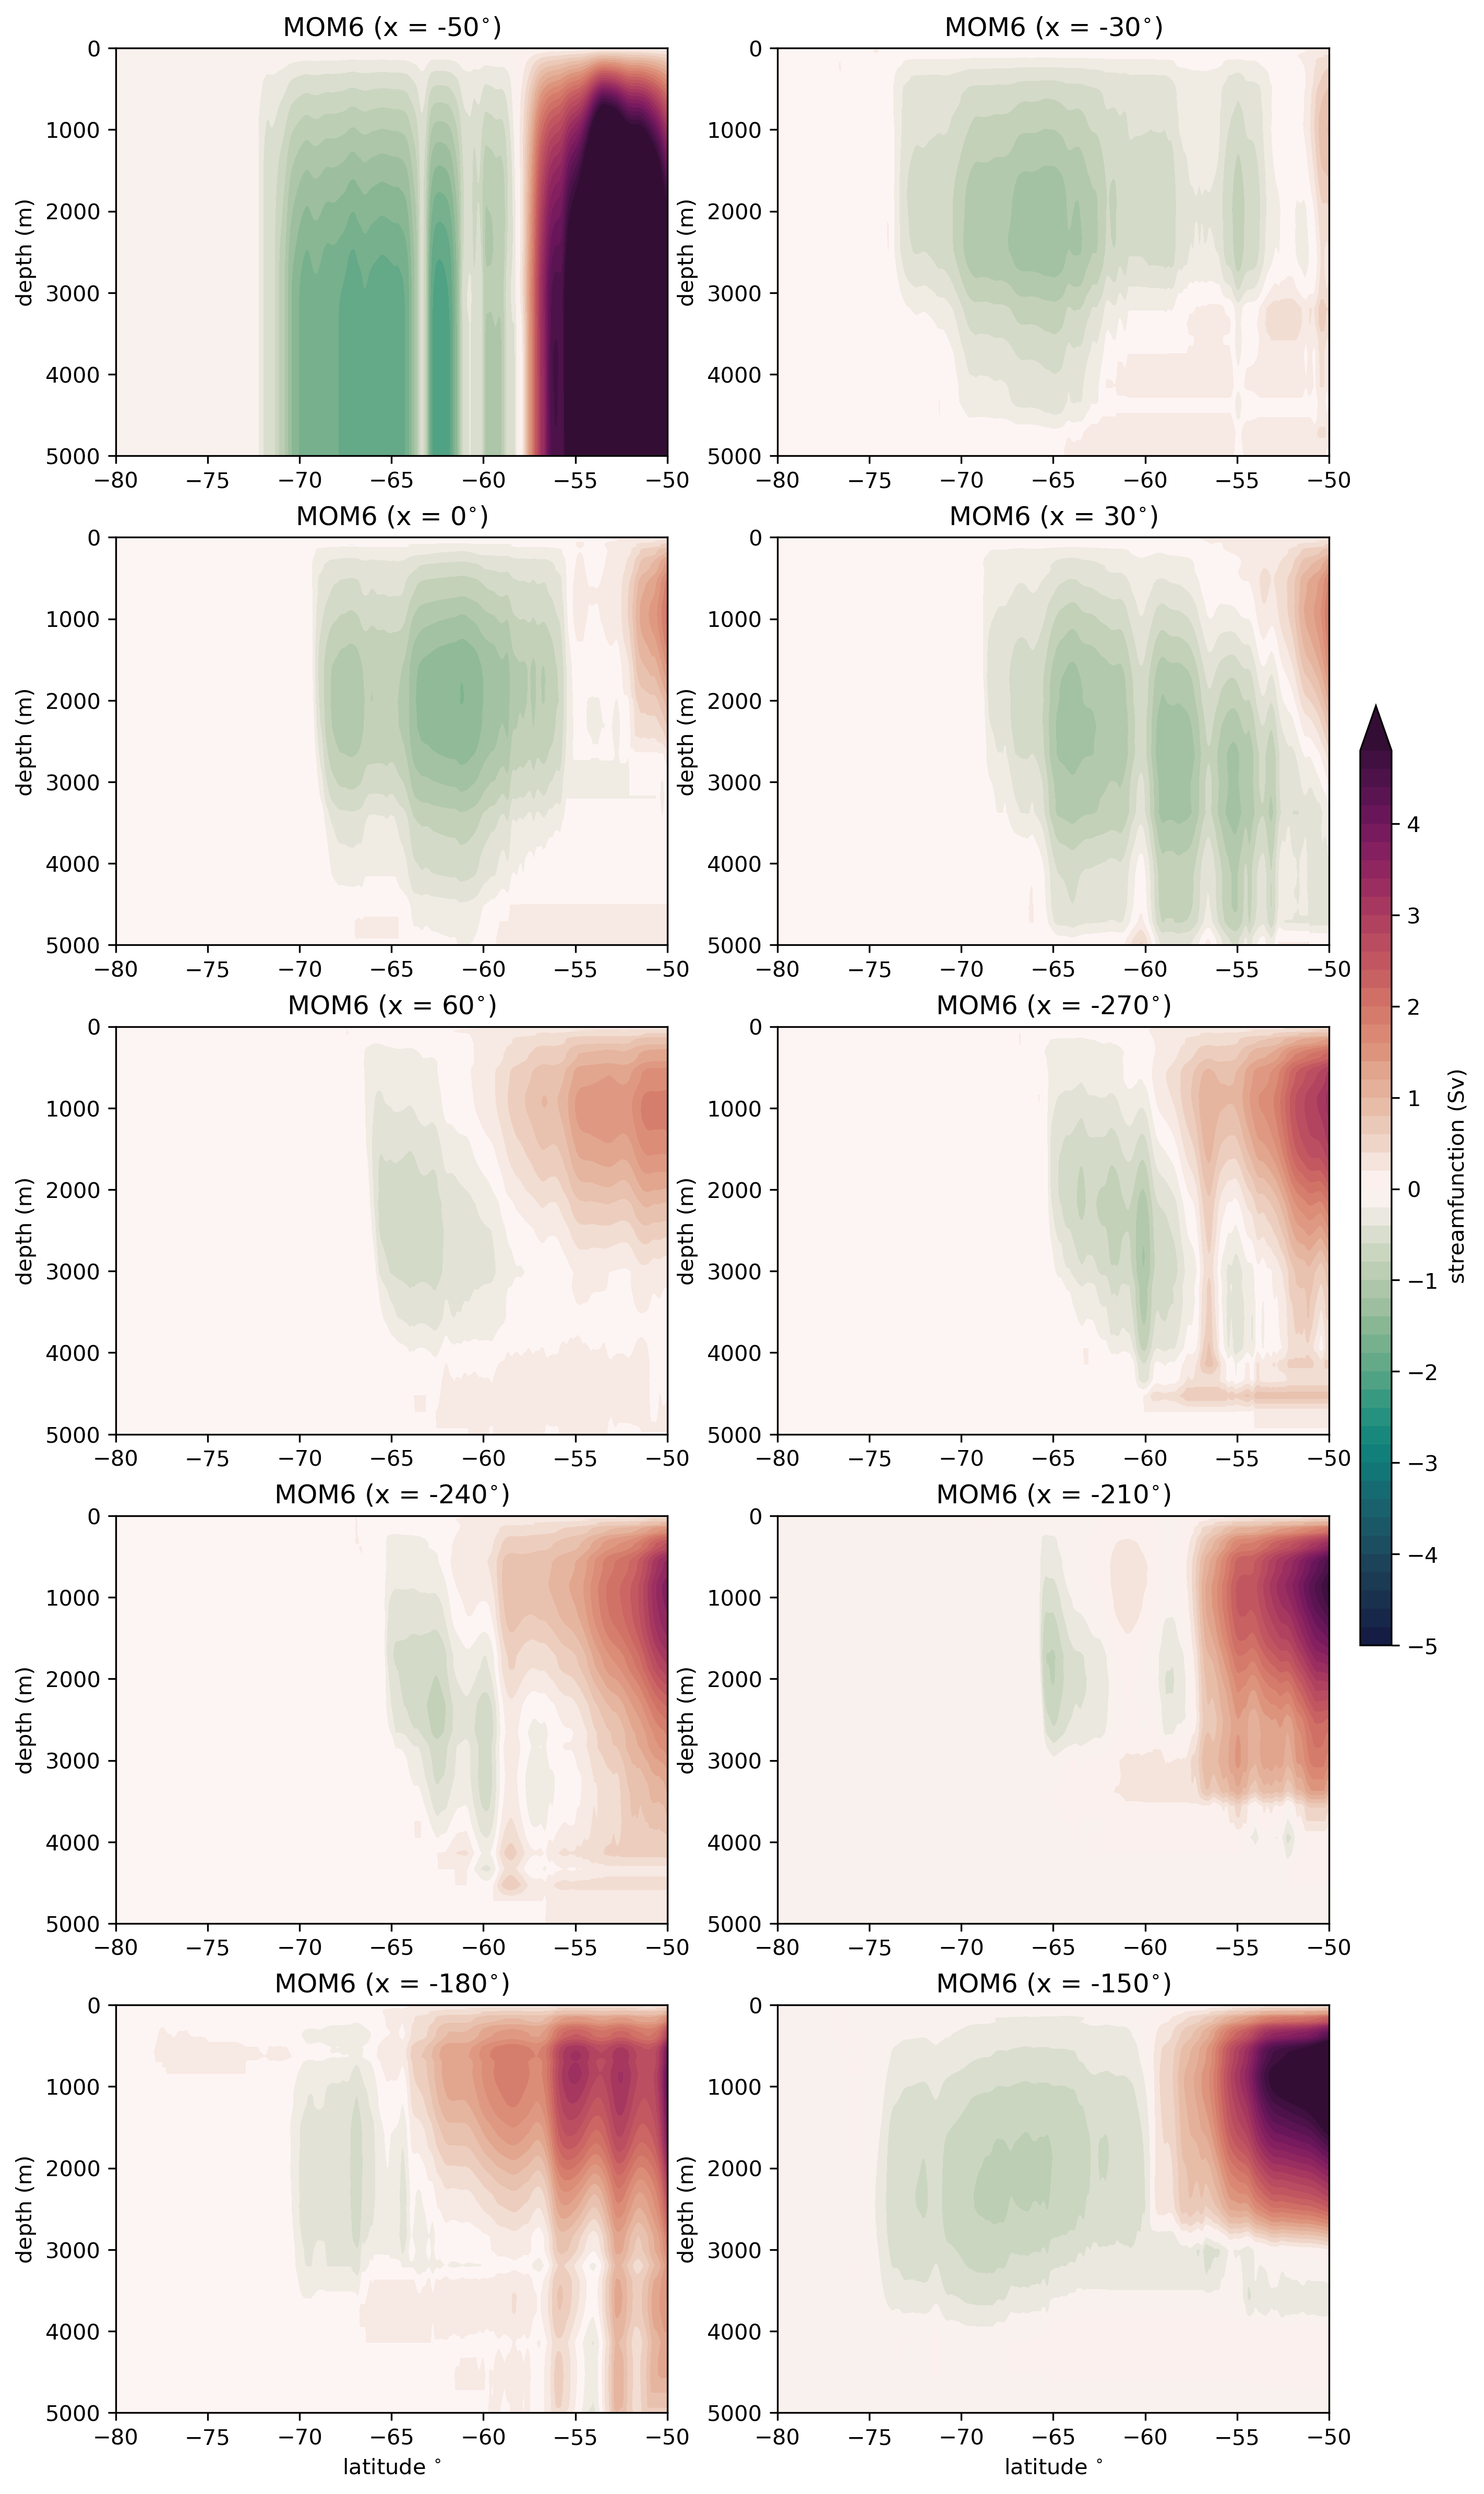

In [34]:
plt.figure(figsize=(10,20),dpi = 300)
#1
ax = plt.subplot(5,2,1)
p1 = transect1.plot.contourf(ax=ax, levels = np.arange(-50,50,2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = -50$^{\circ}$)')
#2
ax = plt.subplot(5,2,2)
p1 = transect2.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = -30$^{\circ}$)')
#3
ax = plt.subplot(5,2,3)
p1 = transect3.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = 0$^{\circ}$)')
#4
ax = plt.subplot(5,2,4)
p1 = transect4.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = 30$^{\circ}$)')
#5
ax = plt.subplot(5,2,5)
p1 = transect5.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = 60$^{\circ}$)')
#6
ax = plt.subplot(5,2,6)
p1 = transect6.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = -270$^{\circ}$)')
#7
ax = plt.subplot(5,2,7)
p1 = transect7.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = -240$^{\circ}$)')
#8
ax = plt.subplot(5,2,8)
p1 = transect8.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = -210$^{\circ}$)')
#9
ax = plt.subplot(5,2,9)
p1 = transect9.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
plt.xlabel('latitude $^{\circ}$')
ax.set_title('MOM6 (x = -180$^{\circ}$)')
#10
ax = plt.subplot(5,2,10)
p1 = transect10.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
plt.xlabel('latitude $^{\circ}$')
plt.ylabel('depth (m)')
ax.set_title('MOM6 (x = -150$^{\circ}$)')


# add the colorabr and legend
# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')